In [22]:
########################################
# DataFrame Setup Function
########################################

def setup_dataframes(dataset_name, infer_mode, features, attribute=None):
    if attribute:
        log_path = dataset_name + '/monitoring_' + attribute + '_quality_log.csv'
        train = 'train_batch'
        infer = 'infer_batch'
        messed_cells = 'total_repairs_grdt_correct'
    else:
        log_path = dataset_name + '/monitoring_quality_log.csv'
#         log_path = 'logs-fev08/' + dataset_name + '/train_all_infer_all/monitoring_quality_log.csv'
        train = 'skip_training_starting_batch'
        infer = 'batch'
        messed_cells = 'repairs_on_correct_cells'

    df_full = pd.read_csv(log_path, sep=';')
    df_full.drop_duplicates(keep='last', inplace=True)

    df = df_full.loc[(df_full['infer_mode'] == infer_mode) & (df_full['features'] == features)]
    df = df.astype({'dk_cells': 'int32', train: 'int32', infer: 'int32', 'total_errors': 'int32',
                                'correct_repairs': 'int32', 'total_repairs_grdt': 'int32', messed_cells: 'int32',
                                'precision': 'float64', 'recall': 'float64', 'f1': 'float64'})
    df = df.sort_values(by=[train, infer])
    
    df_list = []
    for skip_training_starting_batch in df[train].unique().tolist():
        tmp_df = df.loc[df[train] == skip_training_starting_batch]
        tmp_df = tmp_df.sort_values(by=[train, infer])
        df_list.append(tmp_df)

    return df_list

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [24]:
########################################
# Chart Plotting Function
########################################

def plot_charts(df_list, attribute=None):
    if attribute:
        train = 'train_batch'
        infer = 'infer_batch'
    else:
        train = 'skip_training_starting_batch'
        infer = 'batch'

    count = 0

    chart_rows = 20
    chart_columns = 5
    fig, axes = plt.subplots(chart_rows, chart_columns, sharex=True, sharey=True,
                             figsize=(chart_columns * 7, chart_rows * 5))

    for i in range(chart_rows):
        for j in range(chart_columns):
            current_df = df_list[count]
            count += 1
            
            current_df.loc[current_df['dk_cells'] == 0, ['precision', 'recall', 'f1']] = 1

            axes[i, j].plot(infer, 'precision',
                            data=current_df, marker='', color=palette(1), label='precision', linewidth=3)
            axes[i, j].plot(infer, 'recall',
                            data=current_df, marker='', color=palette(2), label='recall', linewidth=3)
            axes[i, j].plot(infer, 'f1',
                            data=current_df, marker='', color=palette(3), label='f1', linewidth=3)
            axes[i, j].legend(loc="lower right")

            skip_training_starting_batch = current_df[train].iloc[0]
            title_str = 'Training up to batch {}'.format(skip_training_starting_batch)
            axes[i, j].set(title=title_str)

            if j == 0:
                axes[i, j].set(ylabel='Percentage')
            if i == chart_rows - 1:
                axes[i, j].set(xlabel='Batch')

    fig.tight_layout()

In [25]:
def plot_charts_acc(df_list, attribute=None, chart_type=1):
    if attribute:
        train = 'train_batch'
        infer = 'infer_batch'
        messed_cells = 'total_repairs_grdt_correct'
    else:
        train = 'skip_training_starting_batch'
        infer = 'batch'
        messed_cells = 'repairs_on_correct_cells'


    count = 0
    prev_values = {'total_errors':  0, 'correct_repairs': 0, 'total_repairs_grdt': 0, messed_cells: 0}

    chart_rows = 20
    chart_columns = 5
    fig, axes = plt.subplots(chart_rows, chart_columns,
                             sharex=True,
                             sharey=True,
                             figsize=(chart_columns * 7, chart_rows * 5))

    for i in range(chart_rows):
        for j in range(chart_columns):
            current_df = df_list[count]
            count += 1
            # Put the last batch in position 20th to compare everything with the "ideal" model (i.e., the last one).
            # if count == 20:
            #     current_df = df_list[99]

            for metric in prev_values.keys():
                # Sets the first entry to the accumulated value up to it.
                current_df.loc[current_df.index[0], metric] = current_df.loc[current_df.index[0], metric] + prev_values[metric]
                prev_values[metric] = current_df.loc[current_df.index[0], metric]
                # Gets the accumulated values.
                current_df[metric] = current_df[metric].cumsum()

            current_df['acc_precision'] = current_df['correct_repairs'] / current_df['total_repairs_grdt']
            current_df['acc_recall'] = current_df['correct_repairs'] / current_df['total_errors']
            current_df['acc_f1'] = (2 * current_df['acc_precision'] * current_df['acc_recall']) \
                / (current_df['acc_precision'] + current_df['acc_recall'])

            current_df['wrong_repairs'] = current_df['total_repairs_grdt'] - current_df['correct_repairs']

            # Workaround to avoid division by zero.
            current_df['relative_dirtiness'] = 0
            current_df.loc[current_df['total_errors'] > 0, 'relative_dirtiness'] \
                = (current_df['total_errors'] - current_df['correct_repairs'] + current_df[messed_cells]) / current_df['total_errors']

            if chart_type == 1:
                # Precision, recall and F1.
                axes[i, j].plot(infer, 'acc_precision',
                                data=current_df, marker='', color=palette(1), label='Precision', linewidth=3)
                axes[i, j].plot(infer, 'acc_recall',
                                data=current_df, marker='', color=palette(2), label='Recall', linewidth=3)
                axes[i, j].plot(infer, 'acc_f1',
                                data=current_df, marker='', color=palette(3), label='F1', linewidth=3)
                y_label = 'Percentage'
                axes[i, j].set_ylim(0,1)
                
            elif chart_type == 2:
                # Numbers of errors and repairs.
                axes[i, j].plot(infer, 'correct_repairs',
                                data=current_df, marker='', color=palette(4), label='Correct Repairs', linewidth=3)            
                axes[i, j].plot(infer, 'total_errors',
                                data=current_df, marker='', color=palette(5), label='Total Errors', linewidth=3)            
                axes[i, j].plot(infer, 'total_repairs_grdt',
                                data=current_df, marker='', color=palette(6), label='Total Repairs', linewidth=3)            
                axes[i, j].plot(infer, 'wrong_repairs',
                                data=current_df, marker='', color=palette(7), label='Wrong Repairs', linewidth=3)            
                axes[i, j].plot(infer, messed_cells,
                                data=current_df, marker='', color=palette(8), label='Cells Messed up', linewidth=3)            
                y_label = 'Accumulated Number'            

            elif chart_type == 3:
                # Relative dirtiness (i.e., how much cleaner/dirtier the dataset becomes)
                axes[i, j].plot(infer, 'relative_dirtiness',
                                data=current_df, marker='', color=palette(9), label='Relative Dirtiness', linewidth=3)
                y_label = 'Relative Dirtiness'

            # To eventually skip some initial too bad results that mess up the y-scale
            if count <= 0:
                continue

            skip_training_starting_batch = current_df[train].iloc[0]
            title_str = 'Training up to {}%'.format(skip_training_starting_batch)
            axes[i, j].set(title=title_str)
            axes[i, j].legend(loc="lower right")

            if j == 0:
                axes[i, j].set(ylabel=y_label)
            axes[i, j].set(xlabel='% of the Dataset')

    fig.tight_layout()

In [26]:
########################################
# Charts: Setup
########################################

plt.rcParams.update({'font.size': 18})
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('tab10')

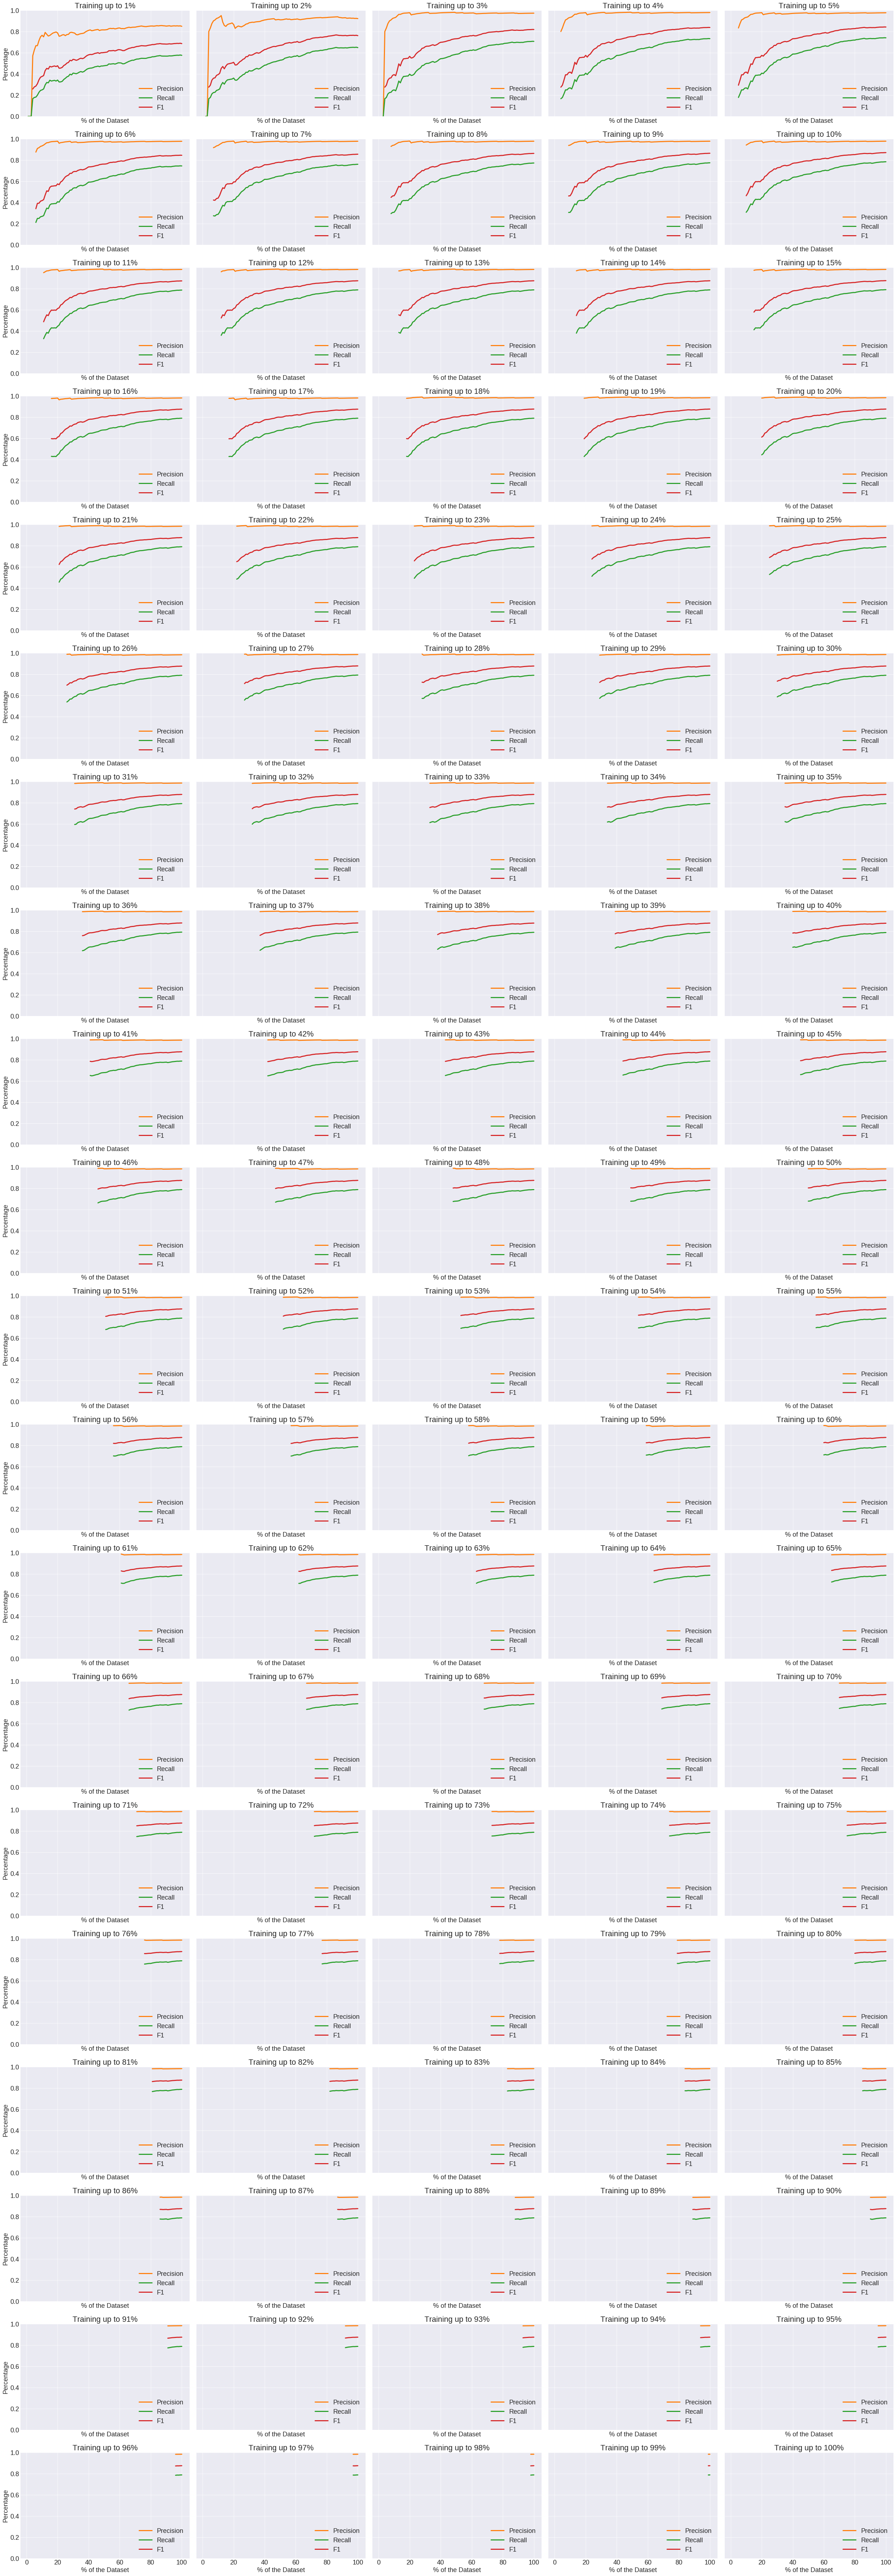

In [27]:
########################################
# Charts: Analysis
########################################

# An attribute name or None.
attribute = None

# 1st argument: 'dk' or 'all'.
# 2nd argument: 'incremental' or 'global'.

# Instant PxR chart.
# plot_charts(setup_dataframes('nypd6', 'all', 'incremental', attribute), attribute)

# Accummulated charts.
# Chart type: 1=PxR; 2=Errors; 3=Relative Dirtiness
chart_type = 1
plot_charts_acc(setup_dataframes('hospital_shuffled', 'dk', 'incremental', attribute), attribute, chart_type)

In [28]:
dataset_name = 'hospital'
df = pd.read_csv(dataset_name + '/monitoring_quality_log.csv', sep=';')

df

,infer_mode,features,train_using_all_batches,skip_training_starting_batch,batch,dk_cells,training_cells,precision,recall,repairing_recall,f1,repairing_f1,detected_errors,total_errors,correct_repairs,total_repairs,total_repairs_grdt,repairs_on_correct_cells,repairs_on_incorrect_cells,rmse
0,dk,global,True,1,1,3,154,1.0,1.0,1.0,1.0,1.0,3,3,3,3,3,0,3,0
1,dk,global,True,1,2,4,154,1.0,0.75,0.75,0.8571428571428571,0.8571428571428571,4,4,3,3,3,0,3,0
2,dk,global,True,1,3,7,154,1.0,0.7142857142857143,0.7142857142857143,0.8333333333333333,0.8333333333333333,7,7,5,5,5,0,5,0
3,dk,global,True,1,4,3,154,0.6666666666666666,0.6666666666666666,0.6666666666666666,0.6666666666666666,0.6666666666666666,3,3,2,3,3,0,3,0
4,dk,global,True,1,5,6,154,0.8333333333333334,0.8333333333333334,0.8333333333333334,0.8333333333333334,0.8333333333333334,6,6,5,6,6,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20594,all,incremental,True,99,99,167,16468,0.6,1.0,1.0,0.7499999999999999,0.7499999999999999,3,3,3,5,5,2,3,0
20595,all,incremental,True,99,100,170,16468,0.16666666666666666,1.0,1.0,0.2857142857142857,0.2857142857142857,1,1,1,6,6,5,1,0
20596,infer_mode,features,train_using_all_batches,skip_training_starting_batch,batch,dk_cells,training_cells,precision,recall,repairing_recall,f1,repairing_f1,detected_errors,total_errors,correct_repairs,total_repairs,total_repairs_grdt,repairs_on_correct_cells,repairs_on_incorrect_cells,rmse
20597,all,global,True,100,100,170,16638,0.16666666666666666,1.0,1.0,0.2857142857142857,0.2857142857142857,1,1,1,6,6,5,1,0


In [29]:
########################################
# Adds infer_mode and features attributes as they're missing in the weight files
########################################

def correct_weight_file(dataset_name, attribute):
#     weight_log_path = 'logs-fev08/' + dataset_name + '/train_all_infer_all/monitoring_' + attribute + '_weight_log'
#     quality_log_path = 'logs-fev08/' + dataset_name + '/train_all_infer_all/monitoring_' + attribute + '_quality_log'
    weight_log_path = dataset_name + '/monitoring_' + attribute + '_weight_log'
    quality_log_path = dataset_name + '/monitoring_' + attribute + '_quality_log'
    

    weight_df = pd.read_csv(weight_log_path + '.csv', sep=';')
    quality_df = pd.read_csv(quality_log_path + '.csv', sep=';')
    
    # Clear extra headers from the middle of the file.
    weight_df = weight_df.loc[weight_df['w0'] != 'w0']
    # Clear log lines not associated to training (but inferring).
    quality_df = quality_df.loc[quality_df['train_batch'] == quality_df['infer_batch'] ]

    # Align the indexes because when trying to assign a column of one DataFrame to another,
    # pandas will try to align the indexes, and failing to do so, insert NaNs.
    weight_df.index = quality_df.index

    # Assign the columns. It works because the original row orders from the files correspond.
    weight_df['infer_mode'] = quality_df['infer_mode']
    weight_df['features'] = quality_df['features']

    weight_df = weight_df.astype({'batch_number': 'int32'})
    weight_df = weight_df.sort_values(by=['batch_number'])
    
    weight_df.to_csv(weight_log_path + '_corrected.csv', index=False, sep=';')
    
#correct_weight_file('soccer', 'season')

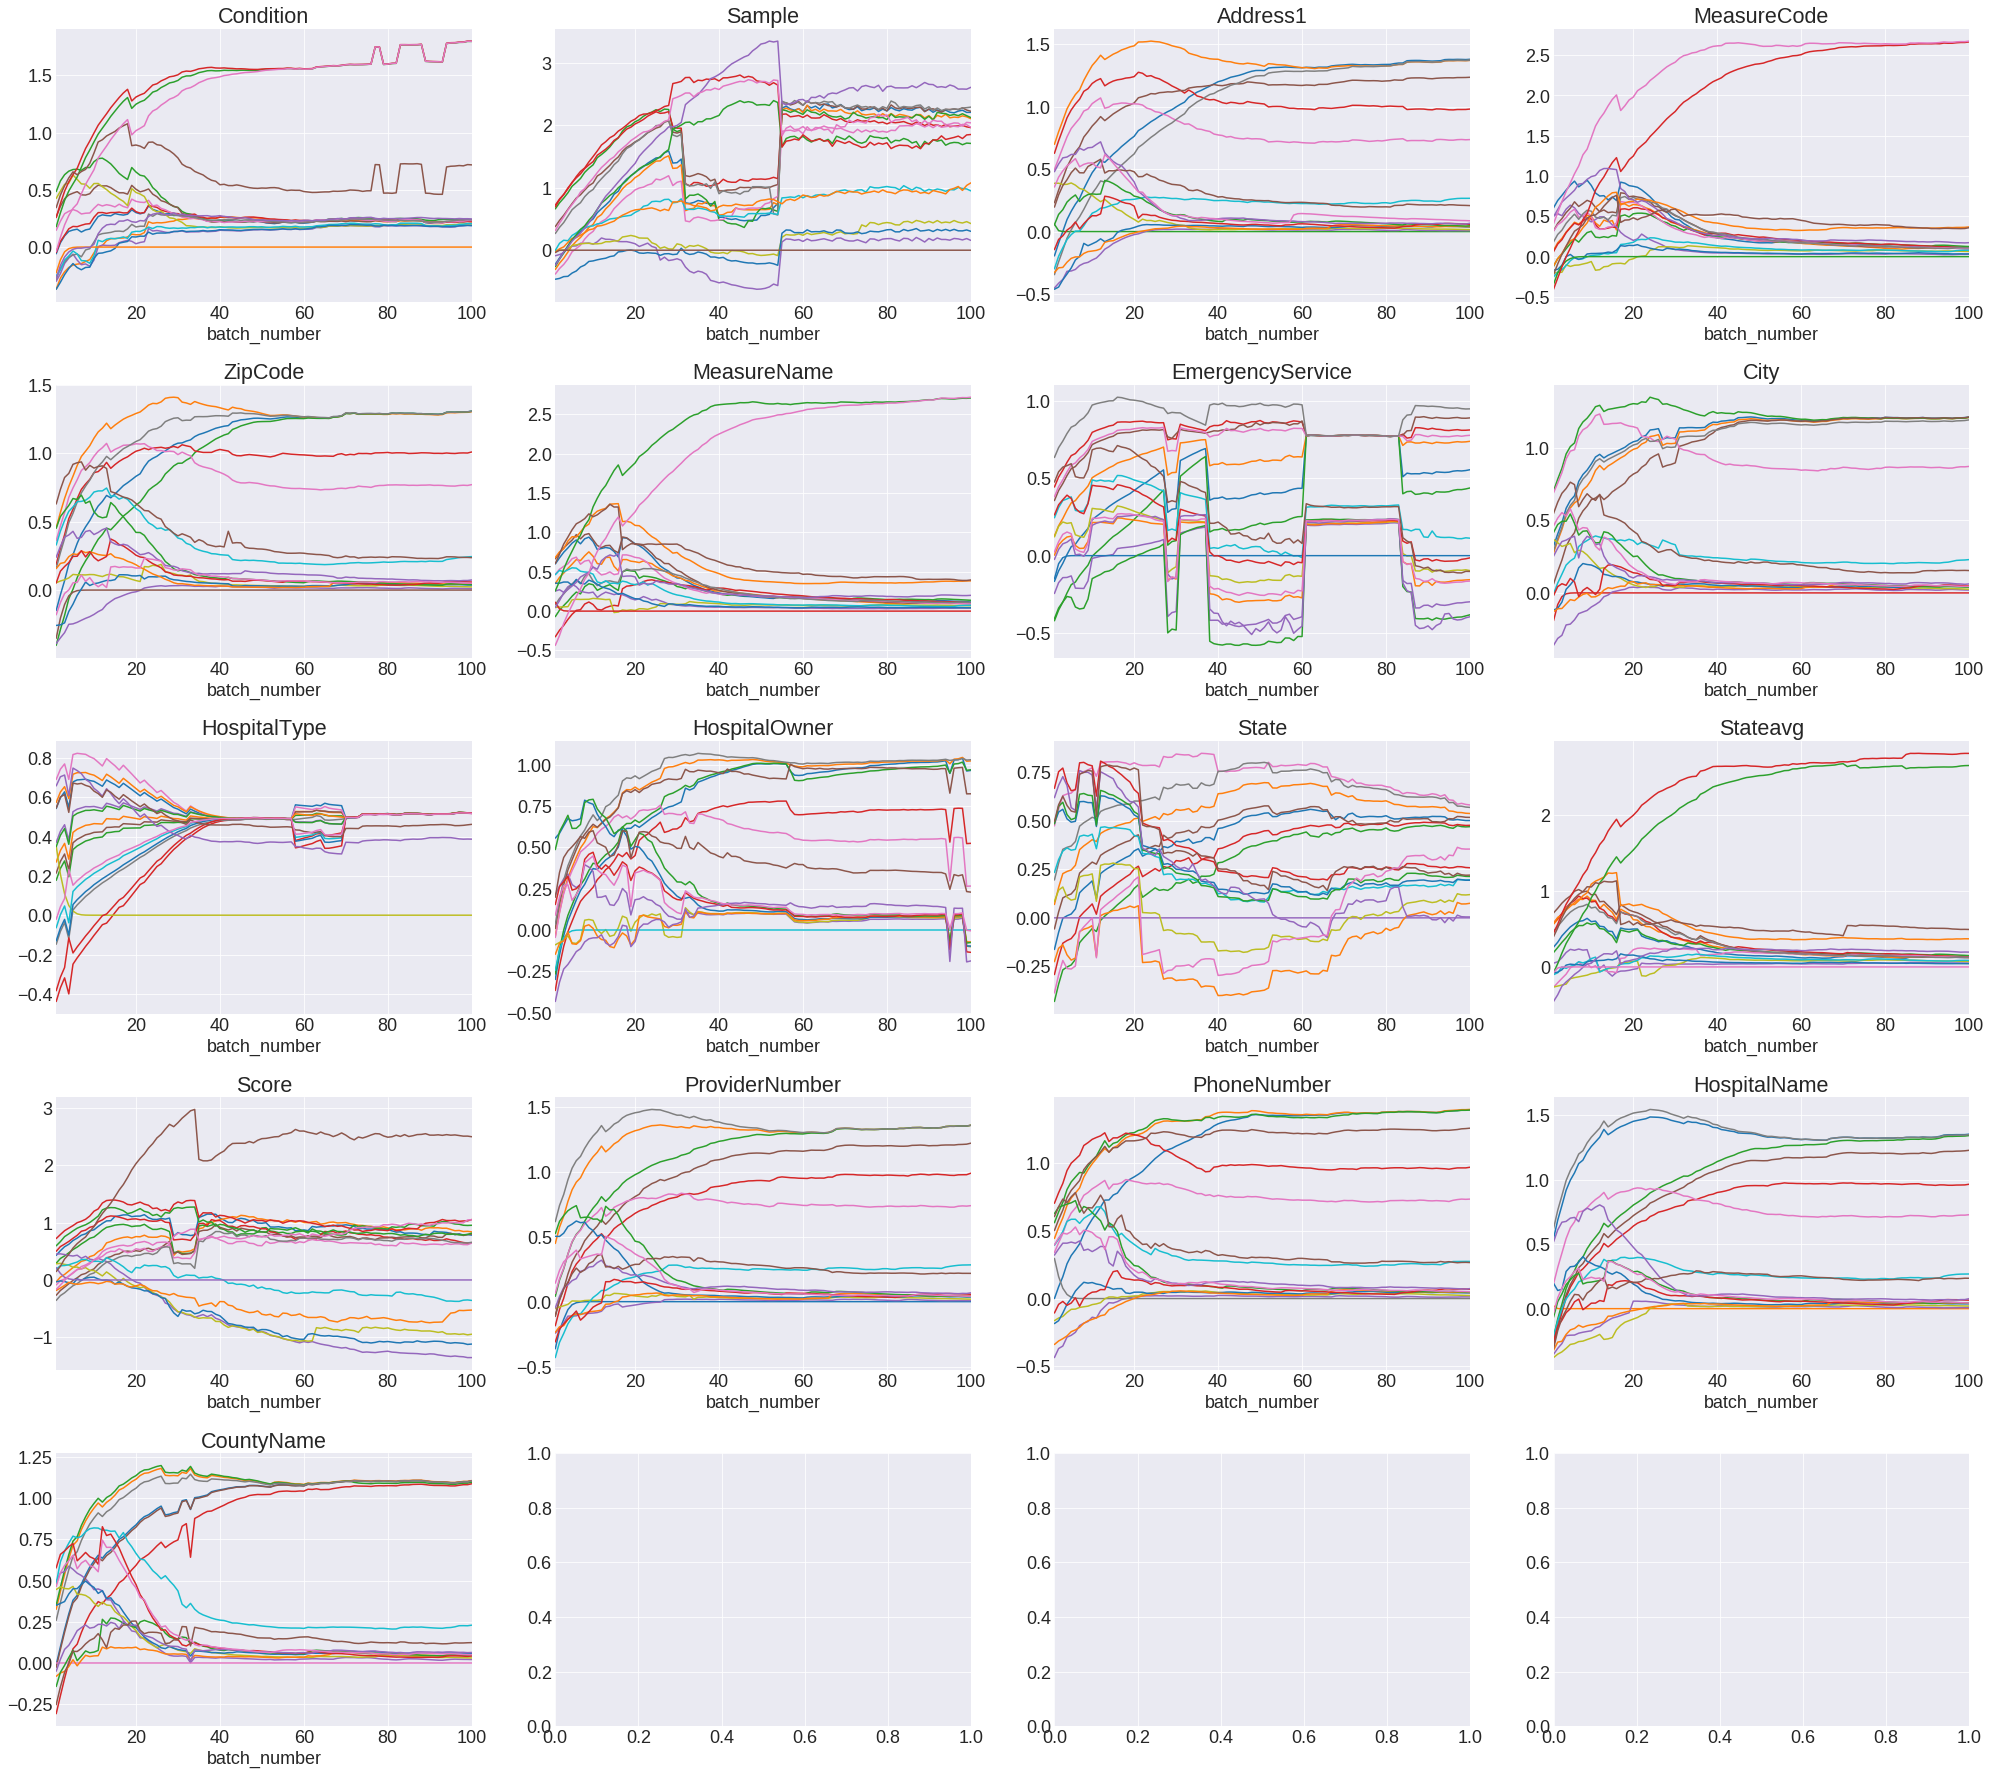

In [30]:
import os.path
import glob
import math

def get_weight_file(dataset_name, infer_mode, features, attribute):
    weight_log_path = dataset_name + '/monitoring_' + attribute + '_weight_log_corrected'

    if not os.path.isfile(weight_log_path):
        correct_weight_file(dataset_name, attribute)

    weight_df = pd.read_csv(weight_log_path + '.csv', sep=';')
    weight_df.drop_duplicates(keep='last', inplace=True)
    weight_df = weight_df.loc[(weight_df['infer_mode'] == infer_mode) & (weight_df['features'] == features)]
    
    return weight_df

def plot_weights(dataset_name, infer_mode, features, attribute=None, show_errors=False):
    
    if attribute:
        weight_df = get_weight_file(dataset_name, infer_mode, features, attribute)
        ax = plt.gca()
        for i in range(len(weight_df.columns) - 3):
            weight_df.plot(kind='line', x='batch_number', y='w' + str(i), ax=ax)

        plt.title(dataset_name + ' - ' + attribute)
        plt.ylabel('Weight Value')
        plt.xlabel('% of the Dataset')
        plt.legend(loc=(1.04, 0))

        plt.show()
        
    else:
        file_names = glob.glob(dataset_name + "/*_weight_log.csv")
        chart_columns = 4
        chart_rows = math.ceil(len(file_names) / chart_columns)
        fig, axes = plt.subplots(chart_rows, chart_columns,
#                                  sharex=True,
#                                  sharey=True,
                                 figsize=(chart_columns * 7, chart_rows * 5)
                                )

        i = 0
        j = 0

        for fname in file_names:
            attr = fname.split('monitoring_')[1].split('_weight')[0]
            
            weight_df = get_weight_file(dataset_name, infer_mode, features, attr)
            
            for w in range(len(weight_df.columns) - 3):
                try:
                    weight_df.plot(kind='line', x='batch_number', y='w' + str(w), ax=axes[i, j], legend=False)
#                     axes[i, j].set_xlim(1,100)
                except:
                    if show_errors:
                        print('Error: {} ({})'.format(attr, w))
                
            axes[i, j].set(title=attr)

            i += (j + 1) // chart_columns
            j = (j + 1) % chart_columns
                
        fig.tight_layout()

# Plot
plot_weights('hospital_shuffled', 'dk', 'incremental')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
import hdbscan

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from itertools import groupby

%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 1, 's': 80, 'linewidths':0}

dataset_name = 'nypd6'
base_path = '/home/dskaster/home/codigos/uwaterloo/holoclean-incremental/experimental_results/'

data_corr = np.loadtxt(base_path + dataset_name + '_corr.csv', delimiter=';')
data_dist = np.loadtxt(base_path + dataset_name + '_dist.csv', delimiter=';')

pca = PCA(n_components=3)
pca_corr = pca.fit_transform(data_corr[:,1:])
pca_dist = pca.fit_transform(data_dist[:,1:])

# tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
# tsne_corr = tsne.fit_transform(data_corr[:,1:])
# tsne_dist = tsne.fit_transform(data_dist[:,1:])

# Clustering.
hdbs = hdbscan.HDBSCAN(min_cluster_size=2)
labels_corr = hdbs.fit_predict(data_corr[:,1:])
labels_dist = hdbs.fit_predict(data_dist[:,1:])

# Computes distances between correlation vectors.
sim_corr_list = []
for corr_vec in data_corr[:, 1:]:
    dist_corr_vec = np.linalg.norm(corr_vec - data_corr[:, 1:], ord=2, axis=1)
    sim_corr_list.append(dist_corr_vec)

# Scales the distances to interval [0, 1].
sim_corr = np.array(sim_corr_list)
sim_corr = sim_corr / sim_corr.max()

# Grouping based on weights' distances. Remember to also change the comparison operator below.
# Weights' distance.
# thresh = 0.6
# groups_ds = data_dist[:, 1:]

# Grouping based on correlation.
thresh = 0.15
groups_ds = sim_corr

# Build the groups based on the threshold.
groups = [set([i]) for i in range(groups_ds.shape[0])]
for i in range(groups_ds.shape[0] - 1):
    for j in range(i + 1, groups_ds.shape[1]):
        
        # Groups based on correlations.
        # Compares both i,j and j,i because conditional entropy is not symmetric.
        if groups_ds[i, j] <= thresh and groups_ds[j, i] <= thresh:
            
#         # Groups based on distance between learned weights.
#         if groups_ds[i, j] >= thresh:

            for idx, g in enumerate(groups):
                if i in g:
                    group_i = idx
                if j in g:
                    group_j = idx
            if group_i != group_j:
                groups[group_i].update(groups[group_j])
                del groups[group_j]
print(groups)
# Eliminate duplicated groups.
groups = list(set(frozenset(item) for item in groups))
            
# palette = sns.color_palette('deep', np.unique(labels_corr).max() + 1)
# colors_corr = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels_corr]
markers = ['o', 'v', 'X', 's', 'P', '*', '<', '^', '>', '+', 'x', 'd', 'D', 'h', '1', '2', '3', '4']

chart_rows = 2
chart_columns = 2
fig, axes = plt.subplots(chart_rows, chart_columns, figsize=(chart_columns * 12, chart_rows * 8), subplot_kw={'projection': '3d'})

axes[0, 0].set_title('PCA Correlations - HDBSCAN Clustering')
for i in range(np.unique(labels_corr).max() + 1):
    mask = (labels_corr == i)
    axes[0, 0].scatter(pca_corr[mask,0], pca_corr[mask,1], pca_corr[mask,2], marker=markers[i] if i>=0 else '.', **plot_kwds)

axes[0, 1].set_title('PCA Distances - HDBSCAN Clustering')
for i in np.unique(labels_dist):
    mask = (labels_dist == i)
    axes[0, 1].scatter(pca_dist[mask,0], pca_dist[mask,1], pca_dist[mask,2], marker=markers[i] if i>=0 else '.', **plot_kwds)

# Create masks for range grouping.
mask = []
for i in range(len(groups)):
    mask.append([False for _ in range(len(data_corr[:, 0]))])
    for j in range(len(data_corr[:, 0])):
        if j in groups[i]:
            mask[i][j] = True

axes[1, 0].set_title('PCA Correlations - Range Grouping (thresh=%6.3f)' % thresh)
for i in range(len(groups)):
    axes[1, 0].scatter(pca_corr[mask[i],0], pca_corr[mask[i],1], pca_corr[mask[i],2], marker=markers[i] if i>=0 else '.', **plot_kwds)

axes[1, 1].set_title('PCA Distances - Range Grouping (thresh=%6.3f)' % thresh)
for i in range(len(groups)):
    axes[1, 1].scatter(pca_dist[mask[i],0], pca_dist[mask[i],1], pca_dist[mask[i],2], marker=markers[i] if i>=0 else '.', **plot_kwds)
    
# axes[1, 0].set_title('TSNE Correlations')
# for i in range(np.unique(labels_corr).max() + 1):
#     mask = (labels_corr == i)
#     axes[1, 0].scatter(tsne_corr[mask,0], tsne_corr[mask,1], tsne_corr[mask,2], marker=markers[i] if i>=0 else '.', **plot_kwds)
    
# axes[1, 1].set_title('TSNE Distances')
# for i in np.unique(labels_dist):
#     mask = (labels_dist == i)
#     axes[1, 1].scatter(tsne_dist[mask,0], tsne_dist[mask,1], tsne_dist[mask,2], marker=markers[i] if i>=0 else '.', **plot_kwds)
    
for i in range(chart_rows):
    for j in range(chart_columns):
        axes[i, j].get_xaxis().set_visible(False)
        axes[i, j].get_yaxis().set_visible(False)

font_size = 10
for i, txt in enumerate(data_corr[:,0]):
    axes[0, 0].text(pca_corr[i,0], pca_corr[i,1], pca_corr[i,2], txt, fontsize=font_size)
    axes[0, 1].text(pca_dist[i,0], pca_dist[i,1], pca_dist[i,2], txt, fontsize=font_size)
    axes[1, 0].text(pca_corr[i,0], pca_corr[i,1], pca_corr[i,2], txt, fontsize=font_size)
    axes[1, 1].text(pca_dist[i,0], pca_dist[i,1], pca_dist[i,2], txt, fontsize=font_size)
    
    
#     axes[1, 0].text(tsne_corr[i,0], tsne_corr[i,1], tsne_corr[i,2], txt, fontsize=font_size)
#     axes[1, 1].text(tsne_dist[i,0], tsne_dist[i,1], tsne_dist[i,2], txt, fontsize=font_size)

ds_attrs = {}
ds_attrs['hospital_shuffled'] = ['Address1', 'City', 'Condition', 'CountyName', 'EmergencyService', 'HospitalName', \
                                 'HospitalOwner', 'HospitalType', 'MeasureCode', 'MeasureName', 'PhoneNumber', \
                                 'ProviderNumber', 'Sample', 'Score', 'State', 'Stateavg', 'ZipCode']

ds_attrs['food5k_shuffled'] = ['address', 'akaname', 'city', 'dbaname', 'facilitytype', 'inspectiondate', \
                               'inspectionid', 'inspectiontype', 'license', 'results', 'risk', 'state', 'zip']

ds_attrs['nypd6'] = ['ADDR_PCT_CD', 'BORO_NM', 'CRM_ATPT_CPTD_CD', 'JURISDICTION_CODE', 'JURIS_DESC', 'KY_CD', \
                     'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PATROL_BORO', 'PD_CD', 'PD_DESC', 'PREM_TYP_DESC']

ds_attrs['soccer'] = ['name', 'surname', 'birthyear', 'birthplace', 'position', 'team', \
                      'city', 'stadium', 'season', 'manager']

chart_columns = 3
chart_rows = math.ceil(len(groups) / chart_columns)
fig2, axes2 = plt.subplots(num=2, nrows=chart_rows, ncols=chart_columns, sharey=True, figsize=(10 * chart_columns, 10 * chart_rows))
w_i = ['w' + str(i) for i in range(groups_ds.shape[0])]

for idx, group in enumerate(groups):
    row_idx = idx // chart_columns
    col_idx = idx % chart_columns
    for i in group:
        weight_df = get_weight_file(dataset_name, 'all', 'incremental', ds_attrs[dataset_name][i])
        weight_df = weight_df.loc[weight_df['batch_number'] == 100, w_i]
        axes2[row_idx, col_idx].plot(weight_df.values.tolist()[0], label=str(i) + ') ' + ds_attrs[dataset_name][i], alpha=1/len(group))
        
    axes2[row_idx, col_idx].legend(loc='best')
    axes2[row_idx, col_idx].set_title('Group: ' + ','.join(str(el) for el in group))

In [31]:
def setup_dataframes_single_execution(dataset_name, approach, infer_mode, features, attribute=None):
    if attribute:
        log_path = dataset_name + '/' + approach + '/monitoring_' + attribute + '_quality_log.csv'
        train = 'train_batch'
        infer = 'infer_batch'
        messed_cells = 'total_repairs_grdt_correct'
    else:
        log_path = dataset_name + '/' + approach + '/monitoring_quality_log.csv'
        train = 'skip_training_starting_batch'
        infer = 'batch'
        messed_cells = 'repairs_on_correct_cells'

    df_full = pd.read_csv(log_path, sep=';')
    df_full.drop_duplicates(keep='last', inplace=True)

    df = df_full.loc[(df_full['infer_mode'] == infer_mode) & (df_full['features'] == features)]
    df = df.astype({'dk_cells': 'int32', train: 'int32', infer: 'int32', 'total_errors': 'int32',
                                'correct_repairs': 'int32', 'total_repairs_grdt': 'int32', messed_cells: 'int32',
                                'precision': 'float64', 'recall': 'float64', 'f1': 'float64'})
    df = df.sort_values(by=[train])
    return df

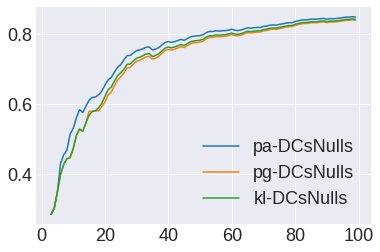

In [33]:
import matplotlib.pyplot as plt

dataset = 'hospital_shuffled'
attribute = None
infer_type = 'dk'
features = 'incremental'
approaches = ['pa-DCsNulls', 'pg-DCsNulls', 'kl-DCsNulls']

if attribute:
    train = 'train_batch'
    infer = 'infer_batch'
    messed_cells = 'total_repairs_grdt_correct'
else:
    train = 'skip_training_starting_batch'
    infer = 'batch'
    messed_cells = 'repairs_on_correct_cells'

measure = 'acc_f1'
metrics = ['total_errors', 'correct_repairs', 'total_repairs_grdt', messed_cells]

dfs = {}
count = 0

for appr in approaches:
    dfs[appr] = setup_dataframes_single_execution(dataset, appr, infer_type, features)

    for metric in metrics:
        # Gets the accumulated values.
        dfs[appr][metric] = dfs[appr][metric].cumsum()    
        
        dfs[appr]['acc_precision'] = dfs[appr]['correct_repairs'] / dfs[appr]['total_repairs_grdt']
        dfs[appr]['acc_recall'] = dfs[appr]['correct_repairs'] / dfs[appr]['total_errors']
        dfs[appr]['acc_f1'] = (2 * dfs[appr]['acc_precision'] * dfs[appr]['acc_recall']) / (dfs[appr]['acc_precision'] + dfs[appr]['acc_recall'])
        dfs[appr]['wrong_repairs'] = dfs[appr]['total_repairs_grdt'] - dfs[appr]['correct_repairs']
    
for appr, df in dfs.items():
    plt.plot(df[measure].values.tolist(), label=appr)
plt.legend(loc='best')

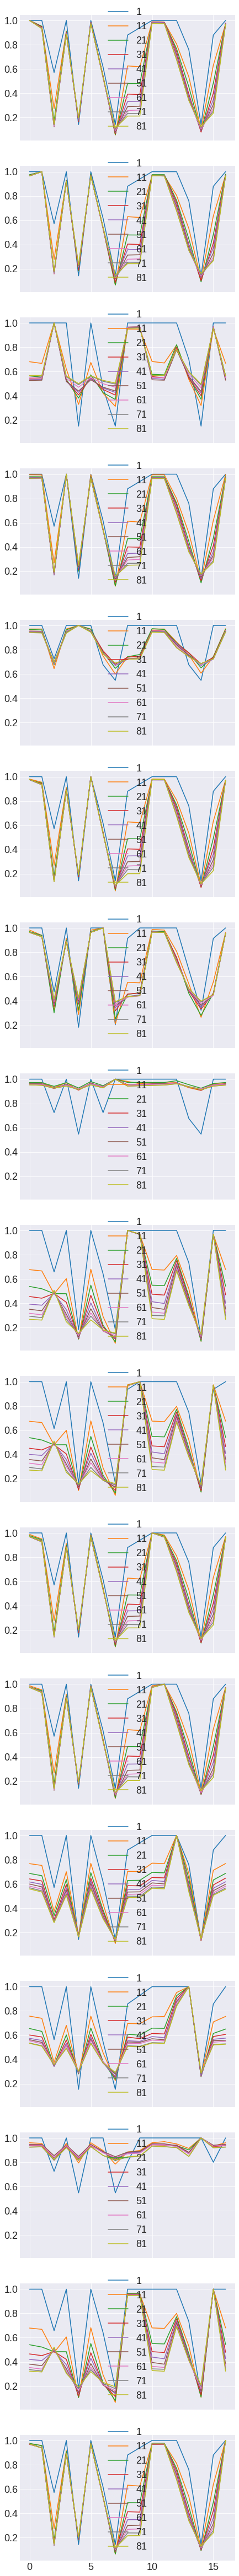

In [34]:
# Analysis of stability of correlation between attributes

from numpy import genfromtxt

dataset = 'hospital_shuffled'

start_batch = 1
end_batch = 85
step = 10

for batch in range(start_batch, end_batch + 1, step):
    corr_current = genfromtxt(dataset + '/' + dataset + '_batch' + str(batch) + '_corr.csv', delimiter=';')
    
    if batch == start_batch:
        num_attrs = corr_current.shape[0]
        fig, axes = plt.subplots(num_attrs, 1, sharex=True, sharey=True,
                             figsize=(1 * 7, num_attrs * 5))
    for attr_idx in range(num_attrs):
        axes[attr_idx].plot(corr_current[attr_idx, 1:], label=batch)

for attr_idx in range(num_attrs):
    axes[attr_idx].legend(loc='best')
        